In [ ]:
!unzip ea


In [3]:
from pylab import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 10, 10

def plotmodel(history,name):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    lrs = history.history['lr']
    epochs = range(1, len(acc) + 1) 
    
    plt.figure(1)                  
    plt.plot(epochs,acc)#mooth_curve(acc))
    plt.plot(epochs,val_acc)#smooth_curve(val_acc))
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train_acc', 'val_acc'], loc='upper left')
    plt.savefig('acc_'+name+'.png')
    
    plt.figure(2)
    plt.plot(epochs, loss)#smooth_curve(loss))
    plt.plot(epochs,val_loss)#smooth_curve(val_loss))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'], loc='upper right')
    plt.savefig('loss_'+name+'.png')
    
    plt.figure(3)
    plt.plot(epochs,lrs)
    plt.ylabel('lr')
    plt.xlabel('epoch')
    plt.legend(['lr'], loc='upper right')
    plt.savefig('lr_'+name+'.png')


Found 416 images belonging to 26 classes.
Found 104 images belonging to 26 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3600)              0         
_________________________________________________________________
dense (Dense)                (None, 26)                93626     
Total params: 93,626
Trainable params: 93,626
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
416/416 [==============================] - 4s 4ms/step - loss: 0.0957 - accuracy: 0.0837 - val_loss: 0.0340 - val_accuracy: 0.3173

Epoch 00001: val_loss improved from inf to 0.03402, saving model to best.hdf5
Epoch 2/40
416/416 [==============================] - 2s 4ms/step - loss: 0.0336 - accuracy: 0.2638 - val_loss: 0.0290 - val_accuracy: 0.4135

Epoch 00002: val_loss improved from 0.03402 to 0.02904, saving m

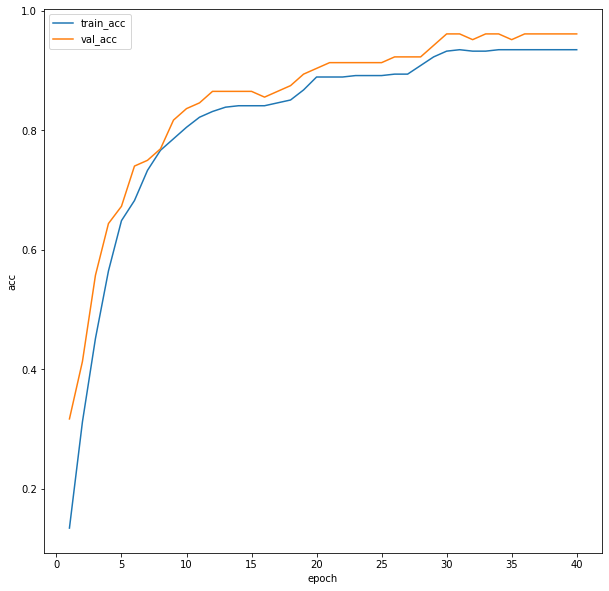

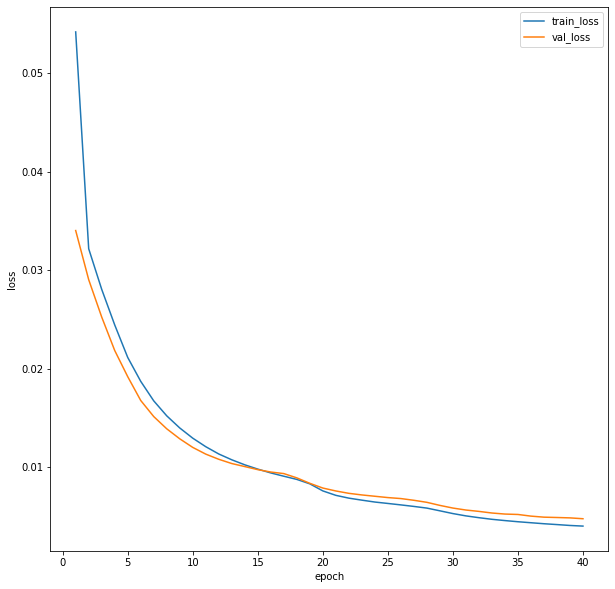

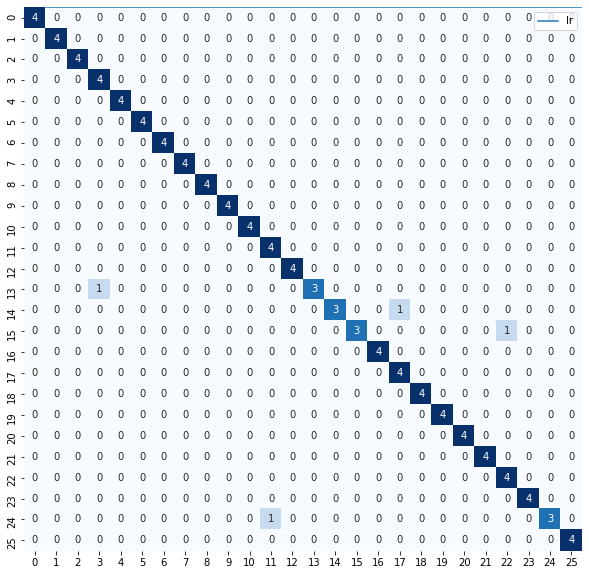

In [5]:
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from keras.activations import softmax, sigmoid
from keras.layers import Flatten
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard, LambdaCallback
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

batch_size = 1

def to_bipolar(img):
  img[img==0] = -1
  img[img>0] = +1
  return img
datagen = ImageDataGenerator(
    preprocessing_function=to_bipolar,
    validation_split=0.2
    )

train = datagen.flow_from_directory(
        'ea',
        target_size=(60, 60),
        color_mode="grayscale",
        class_mode="categorical",
        batch_size=batch_size,
        shuffle=True,
        subset='training'
    )

test = datagen.flow_from_directory(
        'ea',
        target_size=(60, 60),
        color_mode="grayscale",
        class_mode="categorical",
        batch_size=batch_size,
        shuffle=False,
        subset= 'validation'
    )


weight_path="best.hdf5"
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=1, min_lr=0.00001)
callbacks_list = [checkpoint, reduceLROnPlat]

model = Sequential()
model.add(Flatten(input_shape=(60, 60)))
model.add(Dense(26, activation=sigmoid, kernel_initializer='glorot_uniform'))
model.compile(loss='mse', optimizer='SGD', metrics=['accuracy'])
model.summary()

history = model.fit(train, validation_data=test, epochs=40, callbacks=callbacks_list )

plotmodel(history,'perceptron')
model.load_weights('best.hdf5')
model.save('full_model.h5')
pred= model.predict(test, verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)

sns.heatmap(confusion_matrix(test.labels, predicted_class_indices), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues)

print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(test.labels, predicted_class_indices)))
print(classification_report(test.labels, predicted_class_indices))